# HMM POS Tagger: Experiments on Universal Dependencies

In this notebook, we will carry out a series of experiments testing and evaluating our HMM architecture.

## Setup and Data loading

First of all, even though you may be seeing this as just another notebook, it should be mentioned that this notebook was designed to run on Google colab as well. Therefore, we first need to do some housekeeping and make sure we have access to all the codefiles.

In [ ]:
# Setup (Colab only)
!git clone https://github.com/maiossa/backrow-group-hmm-pos-tagger.git repo
%cd repo
!pip install conllu
!pip install seaborn
!bash scripts/download_data.sh

Cloning into 'repo'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 295 (delta 12), reused 7 (delta 7), pack-reused 254 (from 1)
Receiving objects: 100% (295/295), 105.26 KiB | 1.70 MiB/s, done.
Resolving deltas: 100% (140/140), done.
/content/repo/repo
fetching english (gum) ...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2855k  100 2855k    0     0  6454k      0 --:--:-- --:--:-- --:--:-- 6446k
  -> en_gum-ud-dev.conllu -> data/english/gum/dev.conllu
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2857k  100 2857k    0     0  7379k      0 --:--:-- --:--:-- --:--:-- 7384k
  -> en_gum-ud-test.conllu -> data/english/gum/test.conllu
  % Total    % Received %

In [ ]:
!pwd

/content/repo/repo


Once the environment is correctly set up, we can load the data for the different languages.

In [ ]:
from hmm import HMMTagger
from hmm.dataio import load_treebank
import os
import seaborn as sns
from matplotlib import pyplot as plt

LANGUAGES = {
    "German": "data/german/gsd", "Spanish": "data/spanish/ancora",
    "English EWT": "data/english/ewt", "English GUM": "data/english/gum",
    "Czech": "data/czech/cac",
    "Arabic": "data/arabic/nyuad", "Persian": "data/persian/perdt",
    "Slovak": "data/slovak/snk", "Urdu": "data/urdu/udtb",
}

def load_lang(path):
    return load_treebank(f"{path}/train.conllu"), load_treebank(f"{path}/test.conllu")

# Quick check
available = [l for l, p in LANGUAGES.items() if os.path.exists(p)]
print(f"Available: {', '.join(available)}")

Available: German, Spanish, English EWT, English GUM, Czech, Arabic, Persian, Slovak, Urdu


## All Languages Overview

### Tackling different languages: Accuracy

Now that we are set up, let us take a look at the actual model. First things first, we designed it for versatility. As long as the training data follows the Universal Dependencies format, the model should be able to learn and test on it, therefore being useable for a large number of languages.

In this next chunk, we put that versatility to test. We train it on a series of different languages (that we as a group understand) and observe its performance on the test split.

In [ ]:
# Train & evaluate all languages
results = {}
for lang, path in LANGUAGES.items():
    if not os.path.exists(path): continue
    train, test = load_lang(path)

    train_tokens = sum(len(s) for s in train)
    train_vocab = set(t["form"] for s in train for t in s)
    test_vocab = set(t["form"] for s in test for t in s)

    oov_rate = len(test_vocab - train_vocab) / len(test_vocab)  # Unknown words in test
    ttr = len(train_vocab) / train_tokens  # Type-Token-Ratio (morphological complexity)
    avg_sent_len = train_tokens / len(train)

    # Tag ambiguity: avg tags per word type
    word_tags = {}
    for s in train:
        for t in s:
            word_tags.setdefault(t["form"], set()).add(t["upos"])
    tag_ambiguity = sum(len(v) for v in word_tags.values()) / len(word_tags)

    # Train & evaluate
    tagger = HMMTagger(alpha=1e-2)
    tagger.train(train)
    acc, micro, macro = tagger.evaluate(test)

    results[lang] = {
        "Accuracy": acc, "Micro-F1": micro, "Macro-F1": macro,
        "OOV%": oov_rate, "TTR": ttr, "Ambiguity": tag_ambiguity, "AvgLen": avg_sent_len
    }

# Display results
print("="*85)
print(f"{'Lang':<10} {'Acc':>7} {'OOV%':>7} {'TTR':>7} {'Ambig':>7} {'AvgLen':>7}")
print("="*85)
for lang, r in sorted(results.items(), key=lambda x: -x[1]["Accuracy"]):
    print(f"{lang:<10} {r['Accuracy']:>6.1%} {r['OOV%']:>6.1%} {r['TTR']:>7.3f} {r['Ambiguity']:>7.2f} {r['AvgLen']:>7.1f}")
print("="*85)
print("💡 Higher OOV/TTR/Ambiguity → harder for HMM")

Lang           Acc    OOV%     TTR   Ambig  AvgLen
Spanish     94.3%  23.4%   0.082    1.07    32.9
Persian     92.8%  12.0%   0.076    1.13    17.5
Czech       91.0%  25.2%   0.140    1.01    20.2
Urdu        89.5%  21.9%   0.088    1.20    26.9
English GUM  89.1%  29.7%   0.102    1.09    17.7
German      88.6%  33.4%   0.184    1.05    19.4
English EWT  88.5%  32.7%   0.097    1.12    16.5
Slovak      72.4%  64.8%   0.260    1.01     9.6
Arabic      29.0%   0.0%   0.000   17.00    42.6
💡 Higher OOV/TTR/Ambiguity → harder for HMM


| Column                     | Meaning                                                                                                                                                |
| -------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Accuracy**               | The POS-tagging accuracy of your HMM model (percentage of tokens tagged correctly).                                                                    |
| **OOV%**                   | Percentage of test tokens that were **Out-Of-Vocabulary** (not seen in the training set). Higher OOV usually lowers accuracy.                          |
| **TTR** (Type–Token Ratio) | A measure of **vocabulary richness**: (number of unique word types) / (total tokens). Higher TTR = more diverse vocabulary.                            |
| **Ambig**                  | **Ambiguity per word type**: average number of POS tags assigned to each word type in the training data. Higher = more tagging uncertainty.            |
| **AvgLen**                 | **Average token length**: mean number of characters per token in the test set. Languages with longer words tend to show more morphological complexity. |


The above table compares the performance of our model architecture across the before mentioned languages and illustrates how specific linguistic properties affect an HMM model. Languages with moderate type–token ratios and relatively low OOV rates, such as Spanish and Persian, achieve the highest accuracy because most word forms appear in the training data. Languages with richer morphology and higher lexical diversity, such as German and Czech, show lower accuracy due to increased data sparsity. Slovak performs significantly worse because of its extremely high OOV rate and very high lexical variation. Arabic shows the lowest accuracy. Overall, the results demonstrate that vocabulary variation, ambiguity, and unseen words strongly impact the model’s performance across languages.

### Confusion matrices

While the accuracy is a relatively useful metric here, it by far does not tell the full story.

In the end, this is a supervised machine learning model doing a multiclass classification task on 17 classes. Guessing at random would lead us to about 5.8% accuracy, poing from which we are quite far, however, are models are also not 100% precise. Mistakes are happenning, yet accuracy isn't particularly great for telling us where exactly. To answer this question, the easiest thing to do is to call a confusion matrix:


==================== PROCESSING LANGUAGES ====================

Processing German (dir: data/german/gsd)...
  -> train: data/german/gsd/train.conllu
  -> test : data/german/gsd/test.conllu
Processing Spanish (dir: data/spanish/ancora)...
  -> train: data/spanish/ancora/train.conllu
  -> test : data/spanish/ancora/test.conllu
Processing English EWT (dir: data/english/ewt)...
  -> train: data/english/ewt/train.conllu
  -> test : data/english/ewt/test.conllu
Processing English GUM (dir: data/english/gum)...
  -> train: data/english/gum/train.conllu
  -> test : data/english/gum/test.conllu
Processing Czech (dir: data/czech/cac)...
  -> train: data/czech/cac/train.conllu
  -> test : data/czech/cac/test.conllu
Processing Arabic (dir: data/arabic/nyuad)...
  -> train: data/arabic/nyuad/train.conllu
  -> test : data/arabic/nyuad/test.conllu
Processing Persian (dir: data/persian/perdt)...
  -> train: data/persian/perdt/train.conllu
  -> test : data/persian/perdt/test.conllu
Processing Slovak (

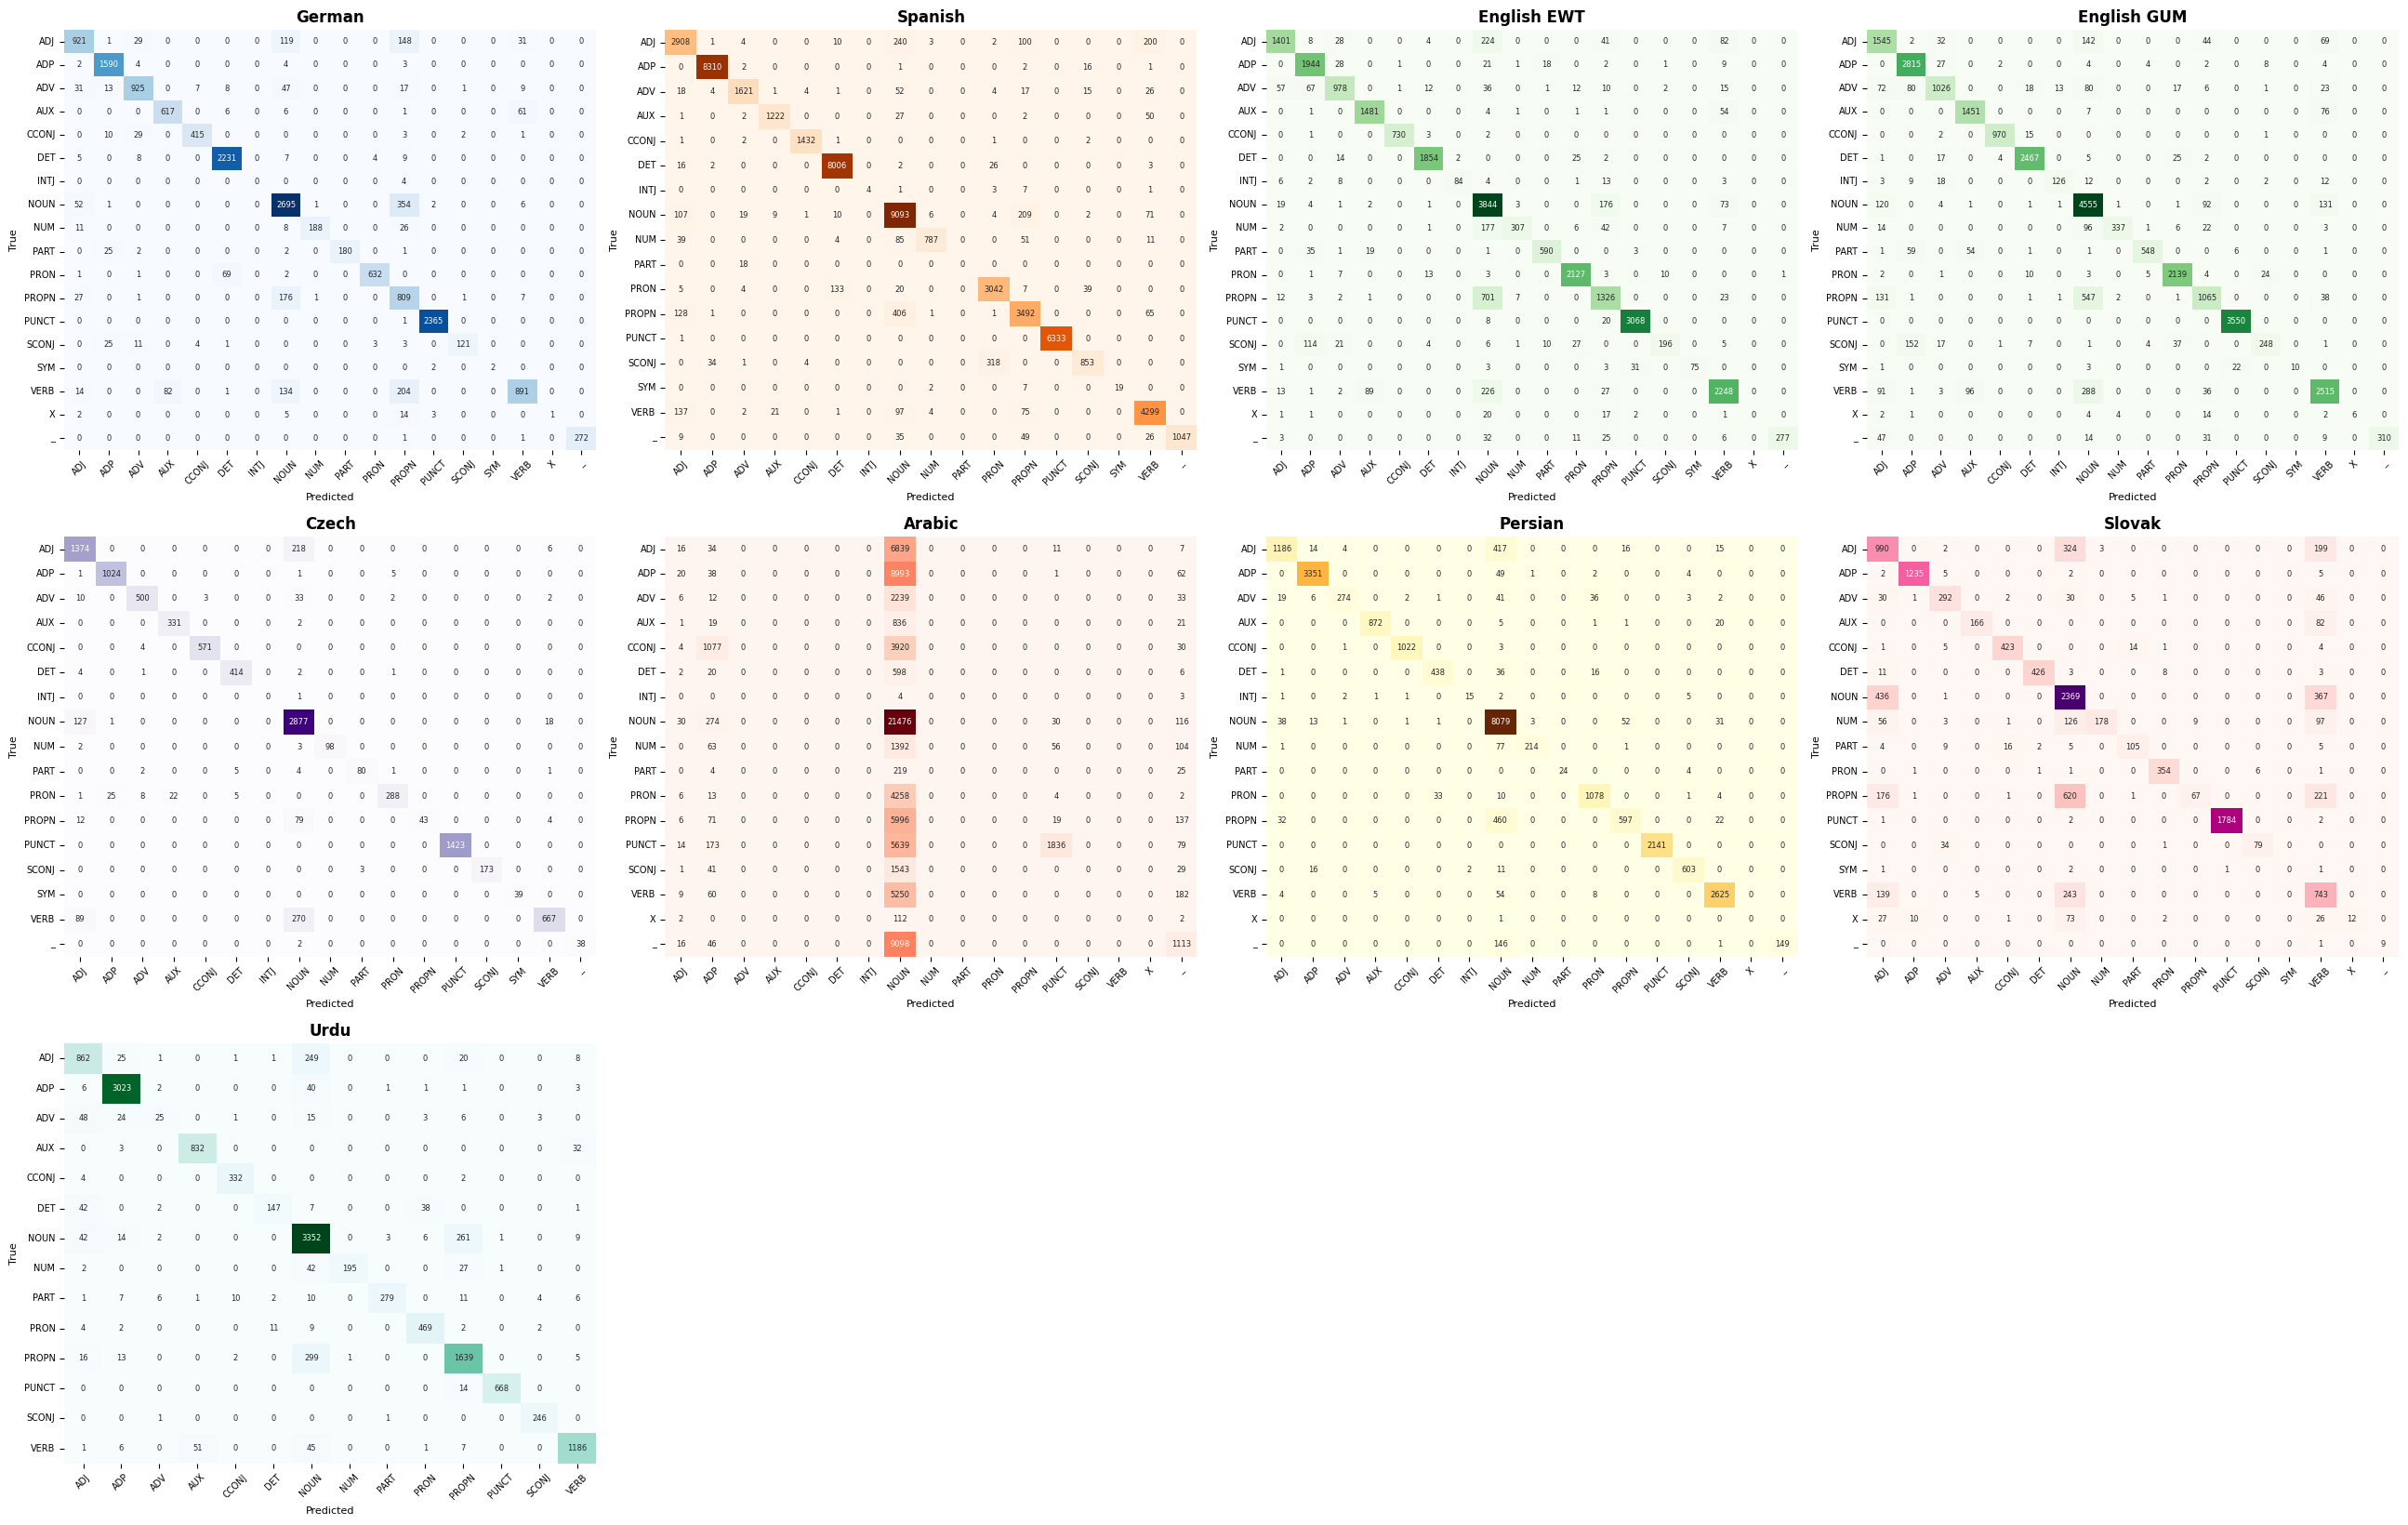

In [ ]:
# =============================================================================
# GENERATE ALL CONFUSION MATRICES IN A GRID (2x4) WITH COLORS & BETTER SIZING
# =============================================================================

import os
import glob
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example: assign a unique color palette per language
LANGUAGE_CMAPS = {
    "German": "Blues",
    "Spanish": "Oranges",
    "English EWT": "Greens",
    "English GUM": "Greens",
    "Czech": "Purples",
    "Arabic": "Reds",
    "Persian": "YlOrBr",
    "Slovak": "RdPu",
    "Urdu": "BuGn"
}

def find_train_test_files(base_dir):
    base_dir = os.path.expanduser(base_dir)
    if not os.path.isdir(base_dir):
        raise FileNotFoundError(f"Directory not found: {base_dir}")

    patterns_train = ["train.conllu", "train-*.conllu", "*train*.conllu"]
    patterns_test  = ["test.conllu", "test-*.conllu", "*test*.conllu"]

    def first_match(dirpath, patterns):
        for p in patterns:
            matches = glob.glob(os.path.join(dirpath, p))
            if matches:
                return matches[0]
        return None

    train_path = first_match(base_dir, patterns_train)
    test_path  = first_match(base_dir, patterns_test)

    if train_path is None or test_path is None:
        for sub in sorted(glob.glob(os.path.join(base_dir, "*"))):
            if os.path.isdir(sub):
                if train_path is None:
                    train_path = first_match(sub, patterns_train) or train_path
                if test_path is None:
                    test_path = first_match(sub, patterns_test) or test_path
            if train_path and test_path:
                break

    if train_path is None or test_path is None:
        raise FileNotFoundError(
            f"Could not locate train/test .conllu files in {base_dir}."
        )

    return train_path, test_path

def evaluate_and_get_tags(tagger, test_data):
    y_true = []
    y_pred = []
    for sent in test_data:
        words = [token['form'] for token in sent]
        true_tags = [token['upos'] for token in sent]
        pred_pairs = tagger.tag(words)
        pred_tags = [tag for _, tag in pred_pairs]
        y_true.extend(true_tags)
        y_pred.extend(pred_tags)
    return y_true, y_pred

def plot_confusion_matrix_axes(ax, lang_name, y_true, y_pred, cmap='Blues'):
    tags_unique = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=tags_unique)

    sns.heatmap(
        cm,
        xticklabels=tags_unique,
        yticklabels=tags_unique,
        annot=True,
        fmt='d',
        cmap=cmap,
        cbar=False,
        ax=ax,
        annot_kws={"size": 6}
    )

    ax.set_title(lang_name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=8)
    ax.set_ylabel('True', fontsize=8)
    ax.tick_params(axis='x', rotation=45, labelsize=7)
    ax.tick_params(axis='y', rotation=0, labelsize=7)

    return cm, tags_unique

# Grid setup (2 rows × 4 columns)
n_langs = len(LANGUAGES)
cols = 4
rows = int(np.ceil(n_langs / cols))
fig, axes = plt.subplots(rows, cols, figsize=(6.5*cols, 5.5*rows))  # square-ish size
axes = axes.flatten()

all_results = {}

print("\n==================== PROCESSING LANGUAGES ====================\n")

for idx, (lang_name, base_dir) in enumerate(LANGUAGES.items()):
    print(f"Processing {lang_name} (dir: {base_dir})...")

    try:
        train_path, test_path = find_train_test_files(base_dir)
        print(f"  -> train: {train_path}")
        print(f"  -> test : {test_path}")
    except FileNotFoundError as e:
        print(f"  ERROR: {e}\n  Skipping {lang_name}.\n")
        continue

    train_data = load_treebank(train_path)
    test_data  = load_treebank(test_path)

    tagger = HMMTagger(alpha=1e-2)
    tagger.train(train_data)

    y_true, y_pred = evaluate_and_get_tags(tagger, test_data)

    cm, tags = plot_confusion_matrix_axes(
        axes[idx], lang_name, y_true, y_pred, cmap=LANGUAGE_CMAPS.get(lang_name, 'Blues')
    )

    all_results[lang_name] = {
        'train_path': train_path,
        'test_path': test_path,
        'tagger': tagger,
        'confusion_matrix': cm,
        'tags': tags
    }

# REMOVE unused subplots
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The confusion matrix analysis across eight languages reveals distinct patterns in HMM POS tagging performance. **Spanish** and **English** show the strongest results, with most tags correctly classified along the diagonal and only moderate confusion between semantically related categories (e.g., ADJ↔NOUN, NOUN↔PROPN). **German** exhibits similar patterns but with more pronounced confusion, particularly between NOUN and PROPN (354 errors) and ADJ and PROPN (148 errors), reflecting the challenges posed by German's capitalization rules where all nouns are capitalized.

**Czech** demonstrates solid performance with the expected ADJ↔NOUN confusion typical of Slavic languages, while **Persian** shows good accuracy overall but notable NOUN↔ADJ mixing (417 errors). **Slovak** struggles more significantly, with substantial confusion between NOUN, ADJ, VERB, and PROPN categories. While this could be due to its rich morphology which poses challenges for the bigram HMM approach, we should also mention that the amount of data we had access to is quite smaller then for many other languages, with only around 100k tokens in total. This could cause problems on its own, but especially so given the before mentioned linguistic complexity,.

**Urdu** performs reasonably well on high-frequency tags (NOUN, ADP, VERB, PUNCT) but shows expected confusion patterns for morphologically ambiguous categories. Across all languages, punctuation (PUNCT) is consistently predicted with near-perfect accuracy, while open-class words (NOUN, VERB, ADJ) and proper nouns (PROPN) remain the primary sources of error. These results confirm that HMM performance strongly correlates with morphological complexity and word order flexibility.

**Arabic** presents the most dramatic failure case: the model almost exclusively predicts NOUN for all tokens, with virtually no correct predictions for other categories. However, why does this happen?

#### Arabic issues

In [ ]:
from collections import Counter

# Arabic in detail
ar_train, ar_test = load_lang(LANGUAGES["Arabic"])

ar_tagger = HMMTagger(alpha=1e-2)
ar_tagger.train(ar_train)

tokens = sum(len(s) for s in ar_train)
vocab = set(t["form"] for s in ar_train for t in s)
test_vocab = set(t["form"] for s in ar_test for t in s)
oov = len(test_vocab - vocab) / len(test_vocab)

# Tag distribution
tag_counts = Counter(t["upos"] for s in ar_train for t in s)
top_tags = tag_counts.most_common(5)

# Check for unusual patterns
empty_words = sum(1 for s in ar_train for t in s if not t["form"].strip())
punct_ratio = tag_counts.get("PUNCT", 0) / tokens

acc, _, _ = ar_tagger.evaluate(ar_test)

print(f"\nArabic:")
print(f"  Accuracy: {acc:.1%}")
print(f"  Train tokens: {tokens:,} | Vocab: {len(vocab):,} | OOV: {oov:.1%}")
print(f"  Empty tokens: {empty_words} | PUNCT ratio: {punct_ratio:.1%}")
print(f"  Top tags: {', '.join(f'{t}:{c}' for t,c in top_tags)}")
print(f"  Unique tags: {len(tag_counts)}")

# Arabic examples
print("Arabic Sample Sentences (first 5 tokens each):")
for i, sent in enumerate(ar_test[:3]):
    words = [t["form"] for t in sent][:5]
    tags = [t["upos"] for t in sent][:5]
    pred = [p[1] for p in ar_tagger.tag([t["form"] for t in sent])][:5]
    print(f"{i+1}. Words: {words}")
    print(f"   Gold:  {tags}")
    print(f"   Pred:  {pred}")
    print()




Arabic:
  Accuracy: 29.0%
  Train tokens: 673,040 | Vocab: 1 | OOV: 0.0%
  Empty tokens: 0 | PUNCT ratio: 8.9%
  Top tags: NOUN:177907, _:82221, ADP:73429, PUNCT:59876, ADJ:55861
  Unique tags: 17
Arabic Sample Sentences (first 5 tokens each):
1. Words: ['_', '_', '_', '_', '_']
   Gold:  ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'NUM']
   Pred:  ['_', 'ADP', 'NOUN', 'NOUN', 'NOUN']

2. Words: ['_', '_', '_', '_', '_']
   Gold:  ['PROPN', 'NUM', 'PUNCT', 'PROPN', 'PROPN']
   Pred:  ['_', 'ADP', 'NOUN', 'NOUN', 'NOUN']

3. Words: ['_', '_', '_', '_', '_']
   Gold:  ['_', 'CCONJ', 'VERB', 'NOUN', 'ADJ']
   Pred:  ['_', 'ADP', 'NOUN', 'NOUN', 'NOUN']



It seems that the Arabic NYUAD corpus on UD has all words masked as `_` due to licensing restrictions! Vocab size is therefore 1 (only the `_` token exists). As such, the corpus only distributes annotations, not the original text. It therefore makes the data quite problematic for our project...


## Detailed Comparison: German vs. Spanish

Now that we know for sure that the model actually works, we can examine its behaviour in detail on 2 different languages:
- **German** (Germanic): Rich morphology, 4 cases, flexible word order
- **Spanish** (Romance): Simpler morphology, fixed SVO order

In [ ]:
from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load data
de_train, de_test = load_lang(LANGUAGES["German"])
es_train, es_test = load_lang(LANGUAGES["Spanish"])

# Train taggers
de_tagger, es_tagger = HMMTagger(alpha=1e-2), HMMTagger(alpha=1e-2)
de_tagger.train(de_train)
es_tagger.train(es_train)

# Results comparison
print("="*50)
print(f"{'Metric':<12} {'German':>10} {'Spanish':>10} {'Δ':>8}")
print("="*50)
for metric in ["Accuracy", "Micro-F1", "Macro-F1"]:
    de_val, es_val = results["German"][metric], results["Spanish"][metric]
    print(f"{metric:<12} {de_val:>10.2%} {es_val:>10.2%} {es_val-de_val:>+8.1%}")
print("="*50)

Metric           German    Spanish        Δ
Accuracy         88.56%     94.33%    +5.8%
Micro-F1         88.56%     94.33%    +5.8%
Macro-F1         82.43%     88.65%    +6.2%


The results show that the POS tagger performs significantly on Spanish than on German. Accuracy and Micro-F1 are about 5.8 percentage points higher for Spanish, indicating that the model is more reliable across all tokens. Macro-F1 is also higher for Spanish by 6.2 points, which suggests that the model handles both frequent and rare POS tags more consistently in Spanish. In contrast, German shows a larger gap between Macro-F1 and Micro-F1, meaning rare German tags are more difficult for the model. Overall, the tagging task appears easier and more stable in Spanish than in German.

In [ ]:
# Function to get predictions and gold labels
def get_predictions(tagger, test_sentences):
    all_gold = []
    all_pred = []

    for sentence in test_sentences:
        words = [tok["form"] for tok in sentence]
        gold = [tok["upos"] for tok in sentence]
        pred = tagger.tag(words)

        if pred and isinstance(pred[0], tuple):
            pred = [p[1] for p in pred]

        all_gold.extend(gold)
        all_pred.extend(pred)

    return all_gold, all_pred
def plot_cm(model_tagger, data_test, axe, title:str, cmap:str = 'Blues'):
    data_gold, data_pred = get_predictions(model_tagger, data_test)
    # Get unique tags
    tags_unique = sorted(set(data_gold + data_pred))
    # Create confusion matrices
    conf_m = confusion_matrix(data_gold, data_pred, labels=tags_unique)
    # German confusion matrix
    sns.heatmap(conf_m, xticklabels=tags_unique, yticklabels=tags_unique,
                annot=False, fmt='d', cmap=cmap, ax=axe, cbar_kws={'label': 'Count'})
    axe.set_title(f'{title} Confusion Matrix', fontsize=14, fontweight='bold')
    axe.set_xlabel('Predicted Tag')
    axe.set_ylabel('True Tag')

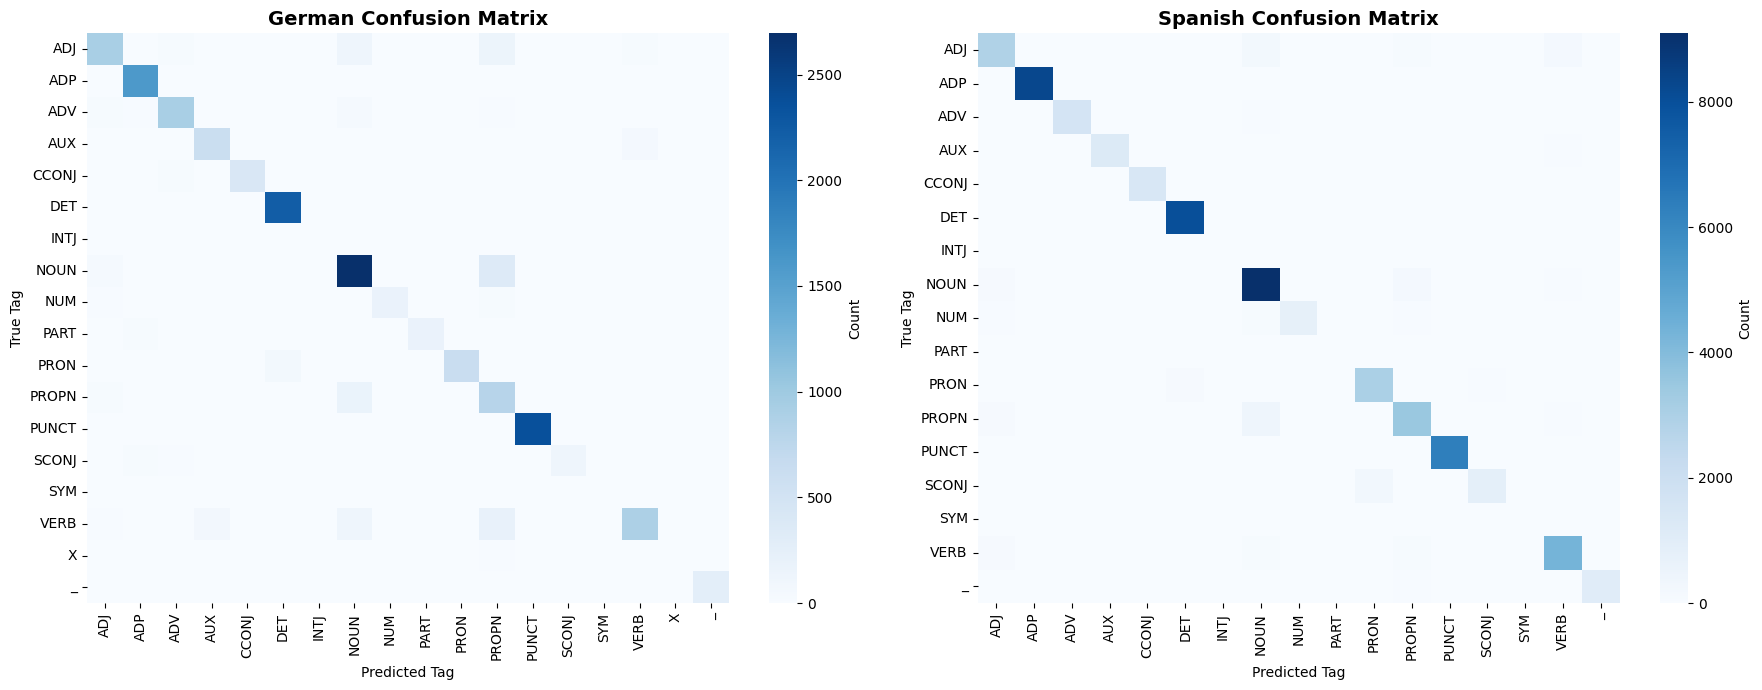

In [ ]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

plot_cm(de_tagger,de_test,axes[0],'German')
plot_cm(es_tagger,es_test,axes[1],'Spanish')

plt.tight_layout()
plt.show()

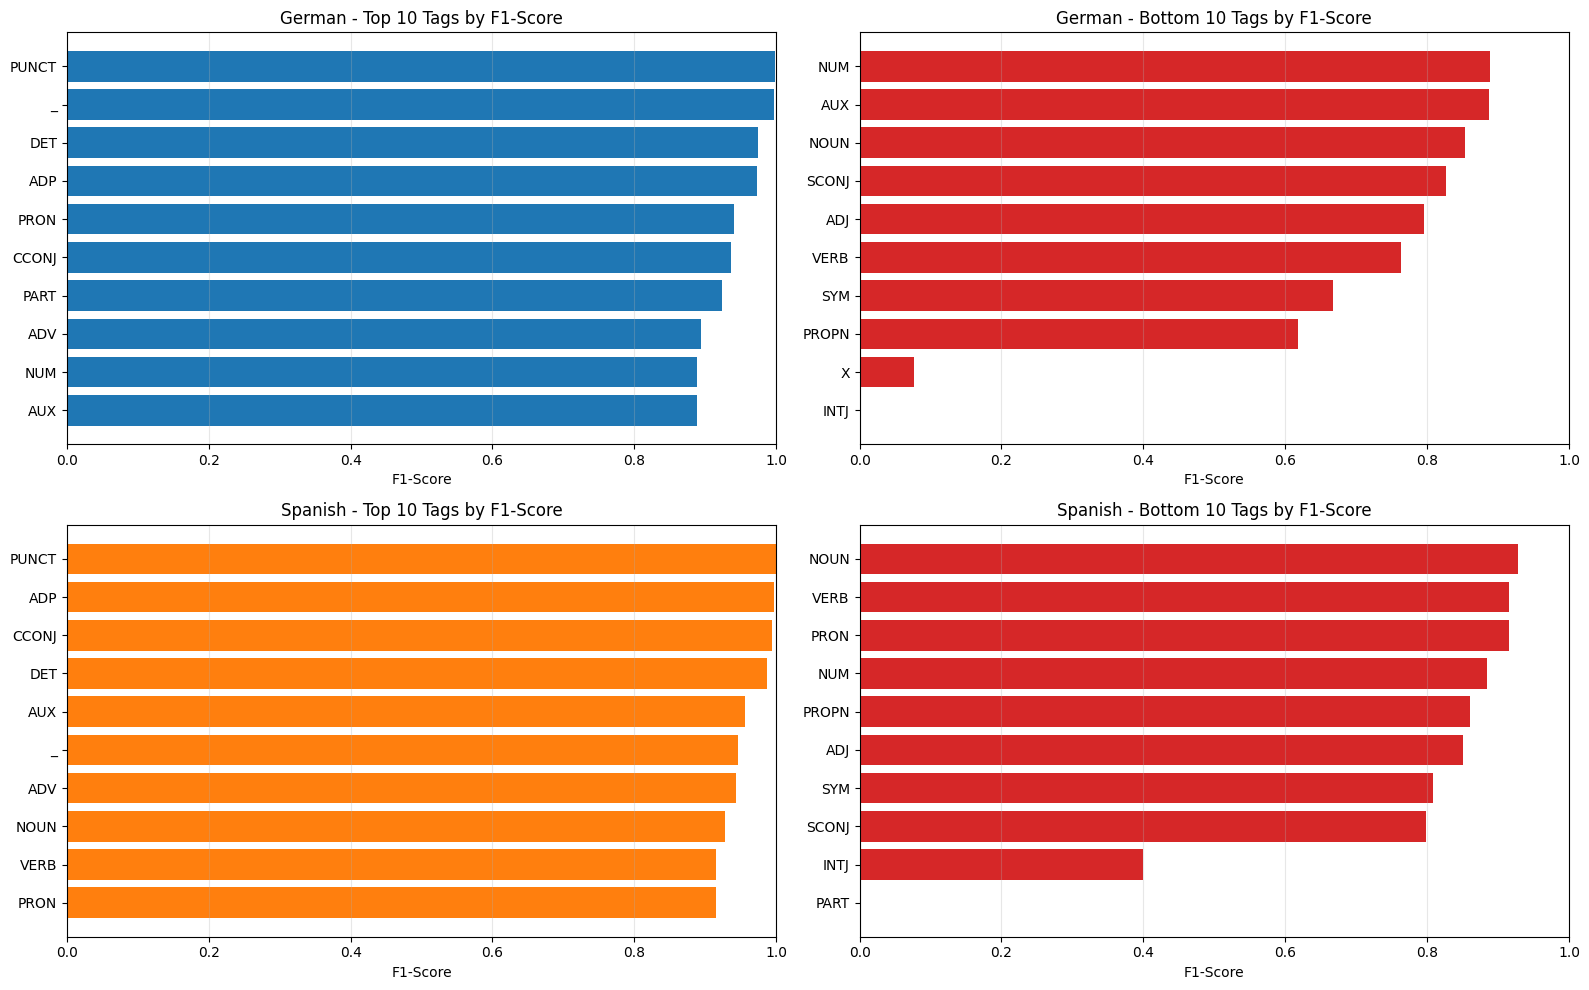


German - Per-Tag Metrics (Top 5):
  Tag  Precision   Recall  F1-Score  Support
PUNCT   0.997049 0.999577  0.998312     2366
    _   1.000000 0.992701  0.996337      274
  DET   0.963299 0.985424  0.974236     2264
  ADP   0.954955 0.991890  0.973072     1603
 PRON   0.989045 0.896454  0.940476      705

Spanish - Per-Tag Metrics (Top 5):
  Tag  Precision   Recall  F1-Score  Support
PUNCT   1.000000 0.999842  0.999921     6334
  ADP   0.994971 0.997360  0.996164     8332
CCONJ   0.993754 0.995136  0.994444     1439
  DET   0.980407 0.993917  0.987115     8055
  AUX   0.975259 0.937117  0.955808     1304


In [ ]:
import pandas as pd

# Per-Tag Performance Analysis
# Analyze F1-score for each individual POS tag to identify strengths and weaknesses.
# Get classification reports
from sklearn.metrics import precision_recall_fscore_support

def get_per_tag_metrics(gold, pred, language):
    labels = sorted(list(set(gold)))
    precision, recall, f1, support = precision_recall_fscore_support(gold, pred, labels=labels, zero_division=0)

    df = pd.DataFrame({
        'Tag': labels,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    }).sort_values('F1-Score', ascending=False)

    return df


german_gold, german_pred = get_predictions(de_tagger, de_test)
spanish_gold, spanish_pred = get_predictions(es_tagger, es_test)
german_metrics = get_per_tag_metrics(german_gold, german_pred, 'German')
spanish_metrics = get_per_tag_metrics(spanish_gold, spanish_pred, 'Spanish')

# Visualize top and bottom performing tags
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# German - Top 10
top_german = german_metrics.head(10)
axes[0, 0].barh(range(len(top_german)), top_german['F1-Score'], color='#1f77b4')
axes[0, 0].set_yticks(range(len(top_german)))
axes[0, 0].set_yticklabels(top_german['Tag'])
axes[0, 0].set_xlabel('F1-Score')
axes[0, 0].set_title('German - Top 10 Tags by F1-Score')
axes[0, 0].set_xlim(0, 1)
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# German - Bottom 10
bottom_german = german_metrics.tail(10)
axes[0, 1].barh(range(len(bottom_german)), bottom_german['F1-Score'], color='#d62728')
axes[0, 1].set_yticks(range(len(bottom_german)))
axes[0, 1].set_yticklabels(bottom_german['Tag'])
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('German - Bottom 10 Tags by F1-Score')
axes[0, 1].set_xlim(0, 1)
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# Spanish - Top 10
top_spanish = spanish_metrics.head(10)
axes[1, 0].barh(range(len(top_spanish)), top_spanish['F1-Score'], color='#ff7f0e')
axes[1, 0].set_yticks(range(len(top_spanish)))
axes[1, 0].set_yticklabels(top_spanish['Tag'])
axes[1, 0].set_xlabel('F1-Score')
axes[1, 0].set_title('Spanish - Top 10 Tags by F1-Score')
axes[1, 0].set_xlim(0, 1)
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# Spanish - Bottom 10
bottom_spanish = spanish_metrics.tail(10)
axes[1, 1].barh(range(len(bottom_spanish)), bottom_spanish['F1-Score'], color='#d62728')
axes[1, 1].set_yticks(range(len(bottom_spanish)))
axes[1, 1].set_yticklabels(bottom_spanish['Tag'])
axes[1, 1].set_xlabel('F1-Score')
axes[1, 1].set_title('Spanish - Bottom 10 Tags by F1-Score')
axes[1, 1].set_xlim(0, 1)
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nGerman - Per-Tag Metrics (Top 5):")
print(german_metrics.head().to_string(index=False))
print("\nSpanish - Per-Tag Metrics (Top 5):")
print(spanish_metrics.head().to_string(index=False))

- Bottom Tags: Least frequent POS tags
- Top Tags: Mst frequent POS tags in the dataset.(usually NOUN, DET, PUNCT, VER)
- Precision: Of all the items the model predicted as positive, how many were actually correct?
- Recall: Of all the actual positive items, how many did the model correctly identify?
- F1-Score: Tells you how well your model balances not missing correct items (recall) and not giving wrong labels (precision).

For example: High F1 for PUNCT means the model rarely misses punctuation and rarely labels other tokens as punctuation incorrectly.

These tables above show the per-POS-tag performance of the model for German and Spanish, focusing on the top 5 most frequent tags. Each tag is evaluated with precision, recall, F1-score, and the number of occurrences (support).

For German, punctuation (PUNCT) is predicted almost perfectly (F1 ≈ 0.998), while determiners (DET) and adpositions (ADP) also achieve high F1-scores above 0.97. Pronouns (PRON) have slightly lower recall, resulting in a lower F1 of 0.94.

For Spanish, the model performs exceptionally well across the top tags. Punctuation (PUNCT) and adpositions (ADP) are nearly perfect (F1 ≈ 0.999–0.995), while determiners (DET) and auxiliary verbs (AUX) also show strong performance (F1 ≈ 0.987 and 0.952).



In [ ]:
# Error Analysis: Top confusions
def get_confusions(tagger, test_data, n=5):
    errors = defaultdict(int)
    for sent in test_data:
        words = [t["form"] for t in sent]
        gold = [t["upos"] for t in sent]
        pred = [p[1] for p in tagger.tag(words)]
        for g, p in zip(gold, pred):
            if g != p: errors[(g, p)] += 1
    return sorted(errors.items(), key=lambda x: -x[1])[:n]

print("Top 5 Confusions:")
print(f"\n{'German':<25} {'Spanish':<25}")
print("-"*50)
de_conf, es_conf = get_confusions(de_tagger, de_test), get_confusions(es_tagger, es_test)
for i in range(5):
    de_str = f"{de_conf[i][0][0]}→{de_conf[i][0][1]} ({de_conf[i][1]})" if i < len(de_conf) else ""
    es_str = f"{es_conf[i][0][0]}→{es_conf[i][0][1]} ({es_conf[i][1]})" if i < len(es_conf) else ""
    print(f"{de_str:<25} {es_str:<25}")

Top 5 Confusions:

German                    Spanish                  
--------------------------------------------------
NOUN→PROPN (354)          PROPN→NOUN (406)         
VERB→PROPN (204)          SCONJ→PRON (318)         
PROPN→NOUN (176)          ADJ→NOUN (240)           
ADJ→PROPN (148)           NOUN→PROPN (209)         
VERB→NOUN (134)           ADJ→VERB (200)           


The confusion lists reveal different sources of difficulty for each language. In German, most mistakes arise from capitalization: since all nouns and many sentence-initial words are capitalized, the model often confuses nouns, proper nouns, adjectives, and even verbs. This leads to frequent NOUN↔PROPN and ADJ→PROPN errors. In Spanish, however, errors come from morphological ambiguity rather than orthography. Words like que, which can function as both a conjunction and a pronoun, cause the largest confusion, and many Spanish adjectives share forms with nouns or verbs. Overall, German confusions stem mainly from orthographic ambiguity, while Spanish confusions reflect flexible word forms and overlapping morphological patterns.



### Examples

Here we show some of the instances in the test sentences in Spanish and German, in order to clearly show the difference between the two models.

In [ ]:

def tag_append(sentence, tagger):
    return [
        (i["form"], i["upos"],j[1])
        for i,j in zip(sentence,tagger.tag([i["form"]
                                                   for i in sentence]))
    ]

def print_tags(st):
    l1=""
    l2=""
    l3=""
    for i,j,k in st:
        m=max(len(i),len(j),len(k))
        if j=="PUNCT" and k=="PUNCT":
            l1+=f"{i} "
            l2+=" "*(len(i)+1)
            l3+=" "*(len(i)+1)
        else:
            l1+=f"{i}{' '*(m-len(i))} "
            l2+=f"{j}{' '*(m-len(j))} "
            l3+=f"\x1b[4;30m\x1b[38;5;198m\x1b[1m{k}\x1b[0m{' '*(m-len(k))} " if j!=k else f"\x1b[92m{k}\x1b[0m{' '*(m-len(k))} "
    print(f"Sentence:  {l1}")
    print(f"True:      {l2}")
    print(f"Predicted: {l3}")


In [ ]:
print("""
Spanish examples:
""")
for i in (
    1045,
    302,
    600,
    37,
    110,
):
    print_tags(tag_append(es_test[i], es_tagger))
    print()



Spanish examples:

Sentence:  Antes , no   obstante , las urnas se   habrán pronunciado el  13-J sobre las posibilidades de  José  Bono  y     de  Rosa  Díez  para el  mismo cargo . 
True:      ADV     PART NOUN       DET NOUN  PRON AUX    VERB        DET NUM  ADP   DET NOUN          ADP PROPN PROPN CCONJ ADP PROPN PROPN ADP  DET DET   NOUN    
Predicted: ADV     ADV  NOUN       DET NOUN  PRON AUX    VERB        DET NOUN ADP   DET NOUN          ADP PROPN PROPN CCONJ ADP PROPN PROPN ADP  DET DET   NOUN    

Sentence:  " _    Golpea a   la  bola con la  mayor claridad que  _    nunca he  visto . 
True:        PRON VERB   ADP DET NOUN ADP DET ADJ   NOUN     PRON PRON ADV   AUX VERB    
Predicted:   PRON VERB   ADP DET NOUN ADP DET ADJ   NOUN     PRON PRON ADV   AUX VERB    

Sentence:  No  me   sorprende nada de  lo   que  _    haga . 
True:      ADV PRON VERB      PRON ADP PRON PRON PRON VERB   
Predicted: ADV PRON VERB      PRON ADP PRON PRON PRON VERB   

Sentence:  El  empate a   dos

In [ ]:
print("""
German examples:
""")
for i in (
    302,
    600,
    37,
    109,
):
    print_tags(tag_append(de_test[i], de_tagger))
    print()



German examples:

Sentence:  " Aber  das Gericht hat dies nicht mit der Eindeutigkeit und   der Klarheit getan , die  wir  uns  gewünscht hätten '' , sagte er   . " 
True:        SCONJ DET NOUN    AUX DET  PART  ADP DET NOUN          CCONJ DET NOUN     VERB    PRON PRON PRON VERB      AUX         VERB  PRON     
Predicted:   CCONJ DET NOUN    AUX DET  PART  ADP DET NOUN          CCONJ DET NOUN     VERB    PRON PRON PRON NOUN      VERB        VERB  PRON     

Sentence:  In  Tokio allerdings sind viele Experten überzeugt , daß   es   sich bei den übrigen Anteilseignern um  Strohmänner handelt . 
True:      ADP PROPN ADV        AUX  DET   NOUN     ADJ         SCONJ PRON PRON ADP DET ADJ     NOUN           ADP NOUN        VERB      
Predicted: ADP PROPN ADV        AUX  DET   NOUN     VERB        SCONJ PRON PRON ADP DET ADJ     NOUN           ADP NOUN        VERB      

Sentence:  Außerdem gehört Herr  Lansky zu  den Anwälten , die  gerade herraus sagen , wie   die Chancen stehen , den Fal

This shows the difference in accuracy between the models, as we can observe a greater amount of mistakes made by the German model, than the Spanish one. This reflects the observations mentioned before.

## Model architecture hypothesis

Finally, we as a group had a number of discussions about how to handle words missing in the model vocabulary, which is something that can be especially important when it comes to generalising. One hypothesis that kept comming up in the discussions was that maybe we should just randomly mask tokens, thus forcing the model to learn how to deal with unknown words. In this next part, we will examine how well this strategy actually works. We will be gradually increasing the percentage of tokens masked from 0 to 25% and see how that impacts the performance of a model trained on one English corpus (gum) but tested on another (ewt), thus explicitly targeting the model's capacity to generalize. As a reminder the accuracy of a gum trained model on the gum test split was about 89.1%

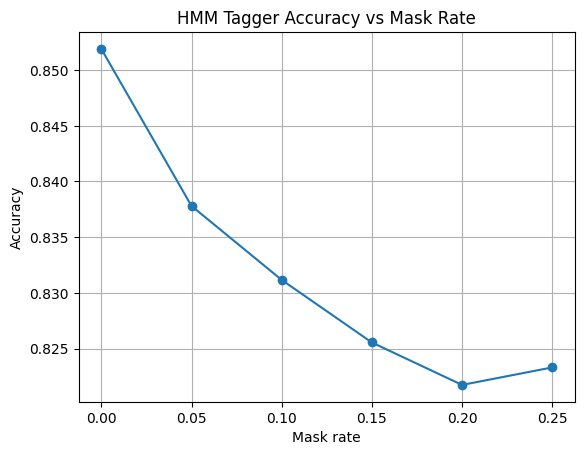

In [ ]:
# A script to test how different masking rates affect the quality of the model.

from hmm.dataio import load_treebank
from hmm.model import HMMTagger

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_sentences = load_treebank("data/english/gum/train.conllu")
test_sentences =  load_treebank("data/english/ewt/test.conllu")

results = []

for mask_rate in np.arange(0, 0.3, 0.05):
    tagger = HMMTagger()
    tagger.train(train_sentences, mask_rate=mask_rate)
    accuracy = tagger.evaluate(test_sentences)[0]
    results.append({"mask_rate": mask_rate, "accuracy": accuracy})

df = pd.DataFrame(results)

# Plot
plt.figure()
plt.plot(df["mask_rate"], df["accuracy"], marker="o")
plt.xlabel("Mask rate")
plt.ylabel("Accuracy")
plt.title("HMM Tagger Accuracy vs Mask Rate")
plt.grid(True)
plt.show()

We can see that masking random tokens is, in fact, very inefficient. It should also be noted that in all cases, the training loop considered words that only apeared once as unknown tokes. However, masking random words on top of that did not yield any benefits.

## 3. Discussion

### Results Summary
| Language | Accuracy | Key Challenge |
|----------|----------|---------------|
| **Spanish** | ~94% | Best: fixed word order, simple morphology |
| **German** | ~89% | Challenging: 4 cases, compounds, flexible order |

### Why Spanish > German?
1. **Morphology**: German has 4 cases + 3 genders → high ambiguity (e.g., "der/die/das")
2. **Word Order**: Spanish = fixed SVO; German = V2/SOV → weaker transition patterns
3. **Capitalization**: German capitalizes ALL nouns → can't distinguish NOUN/PROPN

### Common Error Patterns
- **NOUN ↔ PROPN**: Capitalization ambiguity (both languages)
- **SCONJ → PRON** (Spanish): "que" = conjunction AND pronoun
- **VERB ↔ AUX** (German): Modal verbs function as both

### Random masking
- Random masking turned out to be counterproductive, at least given our data

### HMM Limitations
- Only bigram context (previous tag)
- No subword features (suffixes, morphology)
- UNK tokens lose all lexical information
